In [1]:
# https://www.tensorflow.org/tutorials/text/transformer
# https://arxiv.org/abs/2001.08317
# https://arxiv.org/pdf/1907.00235

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# get historical daily price
symbol = 'SPY'
ticker = yf.Ticker(symbol)
history = ticker.history(period="max")
print(ticker.ticker,history.shape)

SPY (7027, 7)


In [4]:
df = pd.DataFrame()
df['price'] = history.Close
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
df['ret_mean'] = df.log_ret.rolling(21).mean()
df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
df = df.dropna()
df['z_vol']=np.clip(scipy.stats.zscore(df.hist_vol)/10,-1,1)
df['z_ret']=np.clip(scipy.stats.zscore(df.ret_mean)/10,-1,1)

In [5]:
np.mean(df.hist_vol),np.std(df.hist_vol)

(15.975308185776974, 10.388138878566183)

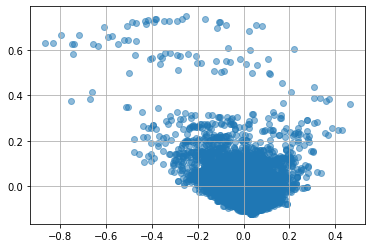

In [6]:
plt.scatter(df.z_ret,df.z_vol,alpha=0.5)
plt.grid(True)

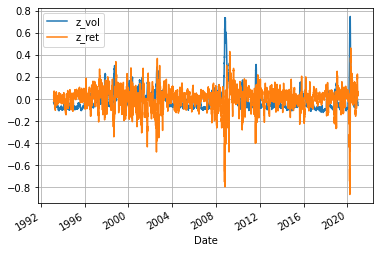

In [7]:
df[['z_vol','z_ret']].plot()
plt.grid(True)

In [8]:
# objectiv
# given x year span of z_vol, z_ret, predict next y day z_vol and z_ret

In [9]:

def etl(history):
    df = pd.DataFrame()
    df['price'] = history.Close
    df.index = history.index
    df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
    df['ret_mean'] = df.log_ret.rolling(21).mean()
    df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
    df = df.dropna()
    df['z_vol']=np.clip(scipy.stats.zscore(df.hist_vol)/10,-1,1)
    df['z_ret']=np.clip(scipy.stats.zscore(df.ret_mean)/10,-1,1)
    df['month']=df.index.month.values/12
    df['day']=df.index.day.values/31
    # add in interest rate.
    return np.stack([df.z_vol.values,df.z_ret.values,df.month.values,df.day.values],axis=-1)

#look_back=252
#look_forward=40
look_back=125
look_forward=10
total_days = look_back+look_forward-1
def chunckify(arr):
    tmp_list = []
    for x in np.arange(total_days,arr.shape[0]-total_days,5):
        tmp = arr[x:x+total_days]
        if tmp.shape != (total_days,4):
            continue
        x,y = tmp[:-1*look_forward,:],tmp[-1*look_forward:,:]
        tmp_list.append((x,y))
    return tmp_list


final_list = []
symbols = ['IWM','SPY','QQQ','GLD','SLV']
ticker_list = yf.Tickers(' '.join(symbols))
for ticker in ticker_list.tickers:
    history = ticker.history(period="max")
    print(ticker.ticker,history.shape)
    arr = etl(history)
    if arr.shape[0] > total_days:
        tmp_list = chunckify(arr)
        final_list.extend(tmp_list)

IWM (5177, 7)
SPY (7027, 7)
QQQ (5485, 7)
GLD (4052, 7)
SLV (3690, 7)


In [10]:
len(final_list),final_list[0][0].shape,final_list[0][1].shape

(4800, (124, 4), (10, 4))

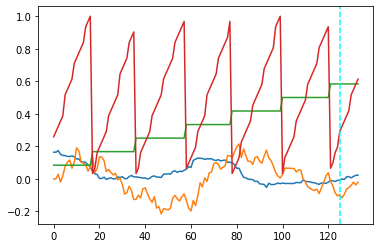

In [11]:
a=final_list[0][0]
b=final_list[0][1]
plt.plot(np.concatenate([a,b]))
plt.axvline(look_back,linestyle='--',color='cyan')

In [12]:
#https://www.tensorflow.org/tutorials/text/transformer
#http://jalammar.github.io/illustrated-transformer

In [13]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline